In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import isoweek
import os
import numpy as np
import scipy.optimize

Nous téléchargeons les données hebdomadaires de CO2 dans l'atmosphère de l'observatoire du Mauna Loa Oberservatory. Le lien suggeré dans MOOC ne marchait pas (le 11 janvier 2024), donc cet site est utilisé. Dans les deux cas, ce sont les données du même observatoire.

In [10]:
if os.path.exists("co2_weekly_mlo.csv"):
    data_path = "co2_weekly_mlo.csv"
else:
    data_path = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_weekly_mlo.csv"

Nous omitterons les premières lignes car ils sont des commentaires. L'unité de la mésure sont des $\mu$mol de $CO_2$ par mol de l'air, aussi appelé "parts per million" (ppm).

In [11]:
co2_data = pd.read_csv(data_path, skiprows=35)
co2_data

year  month  day    decimal  average  ndays  1 year ago  10 years ago  \
0     1974      5   19  1974.3795   333.37      5     -999.99       -999.99   
1     1974      5   26  1974.3986   332.95      6     -999.99       -999.99   
2     1974      6    2  1974.4178   332.35      5     -999.99       -999.99   
3     1974      6    9  1974.4370   332.20      7     -999.99       -999.99   
4     1974      6   16  1974.4562   332.37      7     -999.99       -999.99   
5     1974      6   23  1974.4753   331.73      5     -999.99       -999.99   
6     1974      6   30  1974.4945   331.69      6     -999.99       -999.99   
7     1974      7    7  1974.5137   331.46      6     -999.99       -999.99   
8     1974      7   14  1974.5329   330.83      5     -999.99       -999.99   
9     1974      7   21  1974.5521   330.76      7     -999.99       -999.99   
10    1974      7   28  1974.5712   329.81      4     -999.99       -999.99   
11    1974      8    4  1974.5904   329.85      5     -999.99       -999.99   
12    1974      8   11  1974.6096   329.15      5     -999.99       -999.99   
13    1974      8   18  1974.6288   329.06      6     -999.99       -999.99   
14    1974      8   25  1974.6479   328.33      7     -999.99       -999.99   
15    1974      9    1  1974.6671   328.06      5     -999.99       -999.99   
16    1974      9    8  1974.6863   327.56      4     -999.99       -999.99   
17    1974      9   15  1974.7055   326.72      6     -999.99       -999.99   
18    1974      9   22  1974.7247   326.99      5     -999.99       -999.99   
19    1974      9   29  1974.7438   327.31      5     -999.99       -999.99   
20    1974     10    6  1974.7630   327.07      6     -999.99       -999.99   
21    1974     10   13  1974.7822   327.23      5     -999.99       -999.99   
22    1974     10   20  1974.8014   327.40      5     -999.99       -999.99   
23    1974     10   27  1974.8205   327.64      7     -999.99       -999.99   
24    1974     11    3  1974.8397   327.80      7     -999.99       -999.99   
25    1974     11   10  1974.8589   328.50      6     -999.99       -999.99   
26    1974     11   17  1974.8781   328.61      6     -999.99       -999.99   
27    1974     11   24  1974.8973   328.46      5     -999.99       -999.99   
28    1974     12    1  1974.9164   328.80      5     -999.99       -999.99   
29    1974     12    8  1974.9356   329.39      7     -999.99       -999.99   
...    ...    ...  ...        ...      ...    ...         ...           ...   
2560  2023      6   11  2023.4425   424.13      6      421.00        398.78   
2561  2023      6   18  2023.4616   423.49      7      420.84        398.39   
2562  2023      6   25  2023.4808   422.19      7      420.32        398.78   
2563  2023      7    2  2023.5000   422.62      4      419.91        398.34   
2564  2023      7    9  2023.5192   422.35      5      419.18        397.93   
2565  2023      7   16  2023.5384   421.34      5      418.36        396.93   
2566  2023      7   23  2023.5575   421.28      4      418.03        397.30   
2567  2023      7   30  2023.5767   420.83      6      418.10        396.80   
2568  2023      8    6  2023.5959   420.02      6      417.36        395.65   
2569  2023      8   13  2023.6151   418.98      4      417.25        395.24   
2570  2023      8   20  2023.6342   419.31      2      416.64        395.22   
2571  2023      8   27  2023.6534   419.27      5      416.42        394.45   
2572  2023      9    3  2023.6726   418.64      4      416.27        393.92   
2573  2023      9   10  2023.6918   418.52      2      416.15        393.52   
2574  2023      9   17  2023.7110   418.33      5      415.65        393.79   
2575  2023      9   24  2023.7301   418.29      7      415.34        393.46   
2576  2023     10    1  2023.7493   418.31      6      415.30        393.52   
2577  2023     10    8  2023.7685   418.53      5      415.39        393.58   
2578  2023     10   15  2023.7877   419.46      7      4

Il n'y a pas des semaines sans données.

In [12]:
co2_data[co2_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [year, month, day, decimal, average, ndays, 1 year ago, 10 years ago, increase since 1800]
Index: []

Nous regardons s'il y a des semaines avec des données impossibles, comme des concentrations négatives. Après nous créeons un nouveau DataFrame sans ces semaines.

In [13]:
co2_data.loc[co2_data["average"] < 0]

year  month  day    decimal  average  ndays  1 year ago  10 years ago  \
72    1975     10    5  1975.7603  -999.99      0      326.98       -999.99   
81    1975     12    7  1975.9329  -999.99      0      329.32       -999.99   
82    1975     12   14  1975.9521  -999.99      0      329.68       -999.99   
83    1975     12   21  1975.9712  -999.99      0      329.96       -999.99   
84    1975     12   28  1975.9904  -999.99      0      330.27       -999.99   
110   1976      6   27  1976.4877  -999.99      0      333.05       -999.99   
409   1982      3   21  1982.2178  -999.99      0      342.37       -999.99   
412   1982      4   11  1982.2753  -999.99      0      342.85       -999.99   
413   1982      4   18  1982.2945  -999.99      0      342.66       -999.99   
481   1983      8    7  1983.5986  -999.99      0      340.84       -999.99   
515   1984      4    1  1984.2500  -999.99      0      344.80       -999.99   
516   1984      4    8  1984.2691  -999.99      0      345.23       -999.99   
517   1984      4   15  1984.2883  -999.99      0      345.67       -999.99   
518   1984      4   22  1984.3074  -999.99      0      345.86       -999.99   
1639  2005     10   16  2005.7904  -999.99      0      374.67        358.21   
1780  2008      6   29  2008.4932  -999.99      0      385.53        368.22   
1781  2008      7    6  2008.5123  -999.99      0      385.38        368.88   
1782  2008      7   13  2008.5314  -999.99      0      384.45        367.73   

      increase since 1800  
72                -999.99  
81                -999.99  
82                -999.99  
83                -999.99  
84                -999.99  
110               -999.99  
409               -999.99  
412               -999.99  
413               -999.99  
481               -999.99  
515               -999.99  
516               -999.99  
517               -999.99  
518               -999.99  
1639              -999.99  
1780              -999.99  
1781              -999.99  
1782              -999.99

In [14]:
co2_clean = co2_data.loc[co2_data["average"]>0]
co2_clean

year  month  day    decimal  average  ndays  1 year ago  10 years ago  \
0     1974      5   19  1974.3795   333.37      5     -999.99       -999.99   
1     1974      5   26  1974.3986   332.95      6     -999.99       -999.99   
2     1974      6    2  1974.4178   332.35      5     -999.99       -999.99   
3     1974      6    9  1974.4370   332.20      7     -999.99       -999.99   
4     1974      6   16  1974.4562   332.37      7     -999.99       -999.99   
5     1974      6   23  1974.4753   331.73      5     -999.99       -999.99   
6     1974      6   30  1974.4945   331.69      6     -999.99       -999.99   
7     1974      7    7  1974.5137   331.46      6     -999.99       -999.99   
8     1974      7   14  1974.5329   330.83      5     -999.99       -999.99   
9     1974      7   21  1974.5521   330.76      7     -999.99       -999.99   
10    1974      7   28  1974.5712   329.81      4     -999.99       -999.99   
11    1974      8    4  1974.5904   329.85      5     -999.99       -999.99   
12    1974      8   11  1974.6096   329.15      5     -999.99       -999.99   
13    1974      8   18  1974.6288   329.06      6     -999.99       -999.99   
14    1974      8   25  1974.6479   328.33      7     -999.99       -999.99   
15    1974      9    1  1974.6671   328.06      5     -999.99       -999.99   
16    1974      9    8  1974.6863   327.56      4     -999.99       -999.99   
17    1974      9   15  1974.7055   326.72      6     -999.99       -999.99   
18    1974      9   22  1974.7247   326.99      5     -999.99       -999.99   
19    1974      9   29  1974.7438   327.31      5     -999.99       -999.99   
20    1974     10    6  1974.7630   327.07      6     -999.99       -999.99   
21    1974     10   13  1974.7822   327.23      5     -999.99       -999.99   
22    1974     10   20  1974.8014   327.40      5     -999.99       -999.99   
23    1974     10   27  1974.8205   327.64      7     -999.99       -999.99   
24    1974     11    3  1974.8397   327.80      7     -999.99       -999.99   
25    1974     11   10  1974.8589   328.50      6     -999.99       -999.99   
26    1974     11   17  1974.8781   328.61      6     -999.99       -999.99   
27    1974     11   24  1974.8973   328.46      5     -999.99       -999.99   
28    1974     12    1  1974.9164   328.80      5     -999.99       -999.99   
29    1974     12    8  1974.9356   329.39      7     -999.99       -999.99   
...    ...    ...  ...        ...      ...    ...         ...           ...   
2560  2023      6   11  2023.4425   424.13      6      421.00        398.78   
2561  2023      6   18  2023.4616   423.49      7      420.84        398.39   
2562  2023      6   25  2023.4808   422.19      7      420.32        398.78   
2563  2023      7    2  2023.5000   422.62      4      419.91        398.34   
2564  2023      7    9  2023.5192   422.35      5      419.18        397.93   
2565  2023      7   16  2023.5384   421.34      5      418.36        396.93   
2566  2023      7   23  2023.5575   421.28      4      418.03        397.30   
2567  2023      7   30  2023.5767   420.83      6      418.10        396.80   
2568  2023      8    6  2023.5959   420.02      6      417.36        395.65   
2569  2023      8   13  2023.6151   418.98      4      417.25        395.24   
2570  2023      8   20  2023.6342   419.31      2      416.64        395.22   
2571  2023      8   27  2023.6534   419.27      5      416.42        394.45   
2572  2023      9    3  2023.6726   418.64      4      416.27        393.92   
2573  2023      9   10  2023.6918   418.52      2      416.15        393.52   
2574  2023      9   17  2023.7110   418.33      5      415.65        393.79   
2575  2023      9   24  2023.7301   418.29      7      415.34        393.46   
2576  2023     10    1  2023.7493   418.31      6      415.30        393.52   
2577  2023     10    8  2023.7685   418.53      5      415.39        393.58   
2578  2023     10   15  2023.7877   419.46      7      4

Nous convertirons les premières colonnes en "datetime" de pandas, donc un format de temps.

In [15]:
weeks = pd.to_datetime(co2_clean[["year", "month", "day"]])
weeks

0      1974-05-19
1      1974-05-26
2      1974-06-02
3      1974-06-09
4      1974-06-16
5      1974-06-23
6      1974-06-30
7      1974-07-07
8      1974-07-14
9      1974-07-21
10     1974-07-28
11     1974-08-04
12     1974-08-11
13     1974-08-18
14     1974-08-25
15     1974-09-01
16     1974-09-08
17     1974-09-15
18     1974-09-22
19     1974-09-29
20     1974-10-06
21     1974-10-13
22     1974-10-20
23     1974-10-27
24     1974-11-03
25     1974-11-10
26     1974-11-17
27     1974-11-24
28     1974-12-01
29     1974-12-08
          ...    
2560   2023-06-11
2561   2023-06-18
2562   2023-06-25
2563   2023-07-02
2564   2023-07-09
2565   2023-07-16
2566   2023-07-23
2567   2023-07-30
2568   2023-08-06
2569   2023-08-13
2570   2023-08-20
2571   2023-08-27
2572   2023-09-03
2573   2023-09-10
2574   2023-09-17
2575   2023-09-24
2576   2023-10-01
2577   2023-10-08
2578   2023-10-15
2579   2023-10-22
2580   2023-10-29
2581   2023-11-05
2582   2023-11-12
2583   2023-11-19
2584   202

Avec ceci, il est facile de tester s'ils y a des semaines omises. Ce sont les semaines ou il n'y avait pas de moyen sensible mesuré.

In [16]:
for p1, p2 in zip(weeks[:-1], weeks[1:]):
    delta = p2 - p1
    if delta > pd.Timedelta('7 days'):
        print(p1, p2)

1975-09-28 00:00:00 1975-10-12 00:00:00
1975-11-30 00:00:00 1976-01-04 00:00:00
1976-06-20 00:00:00 1976-07-04 00:00:00
1982-03-14 00:00:00 1982-03-28 00:00:00
1982-04-04 00:00:00 1982-04-25 00:00:00
1983-07-31 00:00:00 1983-08-14 00:00:00
1984-03-25 00:00:00 1984-04-29 00:00:00
2005-10-09 00:00:00 2005-10-23 00:00:00
2008-06-22 00:00:00 2008-07-20 00:00:00


Maintenant, nous pouvons tracer le développement de la concentration de $CO_2$ pendant le temps.

Text(0,0.5,"$\\mu$ mol/mol de CO2 dans l'atmosphère")

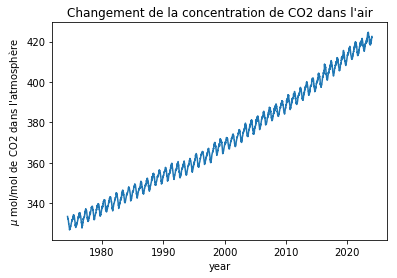

In [17]:
co2_clean.plot(x="decimal", y="average", title="Changement de la concentration de CO2 dans l'air",
              legend=None)
plt.xlabel("year")
plt.ylabel(r"$\mu$ mol/mol de CO2 dans l'atmosphère")

Pour séparer les oscillations et la croissance, nous faisons une separation des données en années.

In [18]:
year_min = co2_clean["year"].iloc[0]
year_max = co2_clean["year"].iloc[-1]
co2_clean["yeartime"]=co2_clean["decimal"]-co2_clean["year"]
co2_clean

year  month  day    decimal  average  ndays  1 year ago  10 years ago  \
0     1974      5   19  1974.3795   333.37      5     -999.99       -999.99   
1     1974      5   26  1974.3986   332.95      6     -999.99       -999.99   
2     1974      6    2  1974.4178   332.35      5     -999.99       -999.99   
3     1974      6    9  1974.4370   332.20      7     -999.99       -999.99   
4     1974      6   16  1974.4562   332.37      7     -999.99       -999.99   
5     1974      6   23  1974.4753   331.73      5     -999.99       -999.99   
6     1974      6   30  1974.4945   331.69      6     -999.99       -999.99   
7     1974      7    7  1974.5137   331.46      6     -999.99       -999.99   
8     1974      7   14  1974.5329   330.83      5     -999.99       -999.99   
9     1974      7   21  1974.5521   330.76      7     -999.99       -999.99   
10    1974      7   28  1974.5712   329.81      4     -999.99       -999.99   
11    1974      8    4  1974.5904   329.85      5     -999.99       -999.99   
12    1974      8   11  1974.6096   329.15      5     -999.99       -999.99   
13    1974      8   18  1974.6288   329.06      6     -999.99       -999.99   
14    1974      8   25  1974.6479   328.33      7     -999.99       -999.99   
15    1974      9    1  1974.6671   328.06      5     -999.99       -999.99   
16    1974      9    8  1974.6863   327.56      4     -999.99       -999.99   
17    1974      9   15  1974.7055   326.72      6     -999.99       -999.99   
18    1974      9   22  1974.7247   326.99      5     -999.99       -999.99   
19    1974      9   29  1974.7438   327.31      5     -999.99       -999.99   
20    1974     10    6  1974.7630   327.07      6     -999.99       -999.99   
21    1974     10   13  1974.7822   327.23      5     -999.99       -999.99   
22    1974     10   20  1974.8014   327.40      5     -999.99       -999.99   
23    1974     10   27  1974.8205   327.64      7     -999.99       -999.99   
24    1974     11    3  1974.8397   327.80      7     -999.99       -999.99   
25    1974     11   10  1974.8589   328.50      6     -999.99       -999.99   
26    1974     11   17  1974.8781   328.61      6     -999.99       -999.99   
27    1974     11   24  1974.8973   328.46      5     -999.99       -999.99   
28    1974     12    1  1974.9164   328.80      5     -999.99       -999.99   
29    1974     12    8  1974.9356   329.39      7     -999.99       -999.99   
...    ...    ...  ...        ...      ...    ...         ...           ...   
2560  2023      6   11  2023.4425   424.13      6      421.00        398.78   
2561  2023      6   18  2023.4616   423.49      7      420.84        398.39   
2562  2023      6   25  2023.4808   422.19      7      420.32        398.78   
2563  2023      7    2  2023.5000   422.62      4      419.91        398.34   
2564  2023      7    9  2023.5192   422.35      5      419.18        397.93   
2565  2023      7   16  2023.5384   421.34      5      418.36        396.93   
2566  2023      7   23  2023.5575   421.28      4      418.03        397.30   
2567  2023      7   30  2023.5767   420.83      6      418.10        396.80   
2568  2023      8    6  2023.5959   420.02      6      417.36        395.65   
2569  2023      8   13  2023.6151   418.98      4      417.25        395.24   
2570  2023      8   20  2023.6342   419.31      2      416.64        395.22   
2571  2023      8   27  2023.6534   419.27      5      416.42        394.45   
2572  2023      9    3  2023.6726   418.64      4      416.27        393.92   
2573  2023      9   10  2023.6918   418.52      2      416.15        393.52   
2574  2023      9   17  2023.7110   418.33      5      415.65        393.79   
2575  2023      9   24  2023.7301   418.29      7      415.34        393.46   
2576  2023     10    1  2023.7493   418.31      6      415.30        393.52   
2577  2023     10    8  2023.7685   418.53      5      415.39        393.58   
2578  2023     10   15  2023.7877   419.46      7      4

Dans cette boucle, nous calculons la moyenne de chaque année séparement.

In [19]:
avg_data = np.zeros([year_max-year_min, 2])
for i in range(year_min, year_max):
    year = co2_clean.loc[co2_clean["year"]==i]
    y_avg = year[["average"]].mean()
    avg_data[i-year_min, 0] = i
    avg_data[i-year_min, 1] = y_avg.values[0]
    
yearly_avg = pd.DataFrame(avg_data, columns=["year", "yearly average"])
yearly_avg

year  yearly average
0   1974.0      329.502121
1   1975.0      331.217447
2   1976.0      332.031765
3   1977.0      333.844423
4   1978.0      335.420755
5   1979.0      336.880192
6   1980.0      338.762308
7   1981.0      340.130577
8   1982.0      341.347551
9   1983.0      343.165882
10  1984.0      344.680000
11  1985.0      346.342885
12  1986.0      347.616154
13  1987.0      349.335000
14  1988.0      351.698269
15  1989.0      353.215849
16  1990.0      354.453846
17  1991.0      355.741346
18  1992.0      356.547115
19  1993.0      357.228077
20  1994.0      358.965192
21  1995.0      360.979245
22  1996.0      362.756346
23  1997.0      363.887500
24  1998.0      366.865385
25  1999.0      368.521538
26  2000.0      369.732830
27  2001.0      371.341154
28  2002.0      373.474808
29  2003.0      375.987500
30  2004.0      377.720385
31  2005.0      380.056078
32  2006.0      382.083585
33  2007.0      384.083462
34  2008.0      385.793469
35  2009.0      387.663077
36  2010.0      390.085192
37  2011.0      391.859808
38  2012.0      394.068868
39  2013.0      396.773269
40  2014.0      398.857500
41  2015.0      401.020769
42  2016.0      404.434423
43  2017.0      406.774906
44  2018.0      408.746346
45  2019.0      411.681346
46  2020.0      414.226154
47  2021.0      416.404808
48  2022.0      418.514615

Nous convertissons le temps dans une année en semaines calendriers car c'est plus intuitive. Après, nous joindrons les données originaux avec la moyenne annuelle.

In [20]:
co2_clean["week"]=52*co2_clean["yeartime"]
co2_merge = pd.merge(co2_clean, yearly_avg, how="outer")
co2_merge

year  month  day    decimal  average  ndays  1 year ago  10 years ago  \
0     1974      5   19  1974.3795   333.37      5     -999.99       -999.99   
1     1974      5   26  1974.3986   332.95      6     -999.99       -999.99   
2     1974      6    2  1974.4178   332.35      5     -999.99       -999.99   
3     1974      6    9  1974.4370   332.20      7     -999.99       -999.99   
4     1974      6   16  1974.4562   332.37      7     -999.99       -999.99   
5     1974      6   23  1974.4753   331.73      5     -999.99       -999.99   
6     1974      6   30  1974.4945   331.69      6     -999.99       -999.99   
7     1974      7    7  1974.5137   331.46      6     -999.99       -999.99   
8     1974      7   14  1974.5329   330.83      5     -999.99       -999.99   
9     1974      7   21  1974.5521   330.76      7     -999.99       -999.99   
10    1974      7   28  1974.5712   329.81      4     -999.99       -999.99   
11    1974      8    4  1974.5904   329.85      5     -999.99       -999.99   
12    1974      8   11  1974.6096   329.15      5     -999.99       -999.99   
13    1974      8   18  1974.6288   329.06      6     -999.99       -999.99   
14    1974      8   25  1974.6479   328.33      7     -999.99       -999.99   
15    1974      9    1  1974.6671   328.06      5     -999.99       -999.99   
16    1974      9    8  1974.6863   327.56      4     -999.99       -999.99   
17    1974      9   15  1974.7055   326.72      6     -999.99       -999.99   
18    1974      9   22  1974.7247   326.99      5     -999.99       -999.99   
19    1974      9   29  1974.7438   327.31      5     -999.99       -999.99   
20    1974     10    6  1974.7630   327.07      6     -999.99       -999.99   
21    1974     10   13  1974.7822   327.23      5     -999.99       -999.99   
22    1974     10   20  1974.8014   327.40      5     -999.99       -999.99   
23    1974     10   27  1974.8205   327.64      7     -999.99       -999.99   
24    1974     11    3  1974.8397   327.80      7     -999.99       -999.99   
25    1974     11   10  1974.8589   328.50      6     -999.99       -999.99   
26    1974     11   17  1974.8781   328.61      6     -999.99       -999.99   
27    1974     11   24  1974.8973   328.46      5     -999.99       -999.99   
28    1974     12    1  1974.9164   328.80      5     -999.99       -999.99   
29    1974     12    8  1974.9356   329.39      7     -999.99       -999.99   
...    ...    ...  ...        ...      ...    ...         ...           ...   
2542  2023      6   11  2023.4425   424.13      6      421.00        398.78   
2543  2023      6   18  2023.4616   423.49      7      420.84        398.39   
2544  2023      6   25  2023.4808   422.19      7      420.32        398.78   
2545  2023      7    2  2023.5000   422.62      4      419.91        398.34   
2546  2023      7    9  2023.5192   422.35      5      419.18        397.93   
2547  2023      7   16  2023.5384   421.34      5      418.36        396.93   
2548  2023      7   23  2023.5575   421.28      4      418.03        397.30   
2549  2023      7   30  2023.5767   420.83      6      418.10        396.80   
2550  2023      8    6  2023.5959   420.02      6      417.36        395.65   
2551  2023      8   13  2023.6151   418.98      4      417.25        395.24   
2552  2023      8   20  2023.6342   419.31      2      416.64        395.22   
2553  2023      8   27  2023.6534   419.27      5      416.42        394.45   
2554  2023      9    3  2023.6726   418.64      4      416.27        393.92   
2555  2023      9   10  2023.6918   418.52      2      416.15        393.52   
2556  2023      9   17  2023.7110   418.33      5      415.65        393.79   
2557  2023      9   24  2023.7301   418.29      7      415.34        393.46   
2558  2023     10    1  2023.7493   418.31      6      415.30        393.52   
2559  2023     10    8  2023.7685   418.53      5      415.39        393.58   
2560  2023     10   15  2023.7877   419.46      7      4

Avec cela, nous pouvons tracer l'oscillation de $CO_2$ en chaque année qui est liée aux différents saisons de l'année.

Text(0.5,1,"Oscillation pendant l'année")

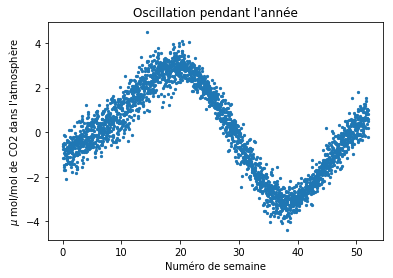

In [21]:
co2_merge["oscillation"]=co2_merge["average"]-co2_merge["yearly average"]

co2_merge.plot(x=["week"], y=["oscillation"], kind="scatter", s=5)
plt.xlabel("Numéro de semaine")
plt.ylabel(r"$\mu$ mol/mol de CO2 dans l'atmosphère")
plt.title("Oscillation pendant l'année")

La moyenne annuelle supprime cette oscillation. Donc, en tracant seulement la moyenne annuelle, on voit clairement l'augmentation de $CO_2$ dans l'atmosphère à cause du changement climatique par nous humains.

Text(0.5,1,'La moyenne annuelle de la concentration de CO2')

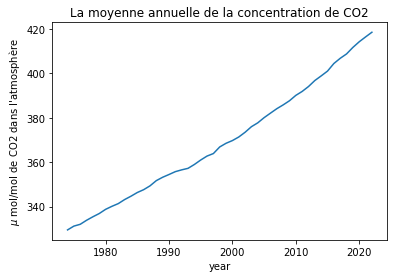

In [44]:
yearly_avg.plot(x=["year"], y=["yearly average"], legend=None)
plt.xlabel("year")
plt.ylabel(r"$\mu$ mol/mol de CO2 dans l'atmosphère")
plt.title("La moyenne annuelle de la concentration de CO2")

Maintenant, on peut faire une extrapolation jusqu'à 2025 comme indiqué dans le sujet. Car il est déjà 2024, nous allons faire la extrapolation jusqu'à 2030.

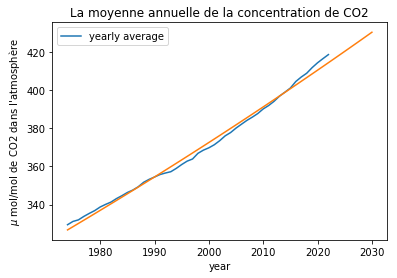

In [59]:
def exponential(x, a, b):
    return np.exp(a*x)+b
    
param, cov = scipy.optimize.curve_fit(exponential, yearly_avg["year"], yearly_avg["yearly average"], p0=[0.003, 10])

yearly_avg.plot(x=["year"], y=["yearly average"])
plt.xlabel("year")
plt.ylabel(r"$\mu$ mol/mol de CO2 dans l'atmosphère")
plt.title("La moyenne annuelle de la concentration de CO2")

year = np.arange(1974, 2031, 1)
plt.plot(year, exponential(year, param[0], param[1]))

Les valeurs estimés dans les prochaines années.

In [58]:
print("Estimation de la concentration en 2025:", exponential(2025, param[0], param[1]), "ppm")
print("Estimation de la concentration en 2030:", exponential(2030, param[0], param[1]), "ppm")

Estimation de la concentration en 2025: 420.2018865870856 ppm
Estimation de la concentration en 2030: 430.20268782943265 ppm


En conclusion, cette courbe montre très bien comment le $CO_2$ monte dans notre atmosphère chaque année depuis les années 1970. Ceci implique l'effet de serre qui augmente la température globale. Pour que nous humains peuvent toujours habiter sur la terre, il est nécessaire que le niveau de $CO_2$ finisse d'augmenter.